[View in Colaboratory](https://colab.research.google.com/github/cxl923cc/Avito/blob/master/Avito_Image_Analysis.ipynb)

# Avito Demand Prediction

**Step 1 - Preparation:**
  * Set up Kaggle API
  * Download image data and train master (zipped file), unzip the files
  * Download Resnet50 from keras library

In [0]:
!pip install kaggle

  Running setup.py bdist_wheel for kaggle ... - done
  Stored in directory: /content/.cache/pip/wheels/2f/ba/5f/b59c5344c9f91464e4f805dba9b091896008d6ea7153edcacf
Successfully built kaggle


In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
imagenet-object-detection-challenge             2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-detection-from-video-challenge  2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-localization-challenge          2029-12-31 07:00:00  Research         Knowledge          8           False  
titanic                                         2020-04-07 00:00:00  Getting Started  Knowledge      11216            True  
house-prices-advanced-regression-techniques     2020-03-01 23:59:00  Getting Started  Knowledge       5248            True  
digit-recognizer                                2020-01-07 00:00:00  Getting Started  Knowledge       2393           False  


In [0]:
!kaggle competitions files -c avito-demand-prediction

name                    size  creationDate         
---------------------  -----  -------------------  
sample_submission.csv    8MB  2018-04-23 21:26:51  
test_jpg.zip            19GB  2018-04-23 22:09:42  
train_jpg.zip           49GB  2018-04-23 23:06:39  
test.csv.zip           107MB  2018-04-24 18:25:00  
periods_test.csv.zip   136MB  2018-04-24 18:25:02  
periods_train.csv.zip  170MB  2018-04-24 18:25:04  
train.csv.zip          308MB  2018-04-24 18:26:58  
test_active.csv.zip      2GB  2018-04-24 18:31:08  
train_active.csv.zip     3GB  2018-04-24 18:44:13  
train_jpg_4.zip         10GB  2018-05-01 22:40:01  
train_jpg_2.zip         10GB  2018-05-01 22:40:05  
train_jpg_1.zip         10GB  2018-05-01 22:40:06  
train_jpg_0.zip         10GB  2018-05-01 22:40:06  
train_jpg_3.zip         10GB  2018-05-01 22:40:06  


In [0]:
!kaggle competitions download -c avito-demand-prediction -f train_jpg_0.zip   
#Download of train_jpg_0.zip started at 8:53pm finished at 8:55pm

train_jpg_0.zip: Downloaded 10GB of 10GB


In [0]:
!kaggle competitions download -c avito-demand-prediction -f train.csv.zip

train.csv.zip: Downloaded 308MB of 308MB


In [0]:
!unzip .kaggle/competitions/avito-demand-prediction/train.csv.zip
#After unzip, train.csv is under the home folder

Archive:  .kaggle/competitions/avito-demand-prediction/train.csv.zip
  inflating: train.csv               


In [0]:
!ls .kaggle/competitions/avito-demand-prediction/
#train.csv.zip  train_jpg_0.zip are under the kaggle folder

train.csv.zip  train_jpg_0.zip


In [0]:
import os

import numpy as np
import pandas as pd
from keras.preprocessing import image
import keras.applications.resnet50 as resnet50
import keras.applications.xception as xception
import keras.applications.inception_v3 as inception_v3
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [0]:
resnet_model = resnet50.ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


**Step 2 - Read Data:**
  * Read train master file into a dataframe 'train_df'
  * Read 1000-10000 images

In [0]:
train_df = pd.read_csv('train.csv')
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [0]:
images_dir = os.path.expanduser(os.path.join('~', 'avito_images'))
if not os.path.exists(images_dir):
    os.makedirs(images_dir)

avito_images  datalab  train.csv


In [0]:
from datetime import datetime
start=datetime.now()

import zipfile

NUM_IMAGES_TO_EXTRACT = 10000

with zipfile.ZipFile('.kaggle/competitions/avito-demand-prediction/train_jpg_0.zip', 'r') as train_zip:
    files_in_zip = sorted(train_zip.namelist())
    for idx, file in enumerate(files_in_zip[:NUM_IMAGES_TO_EXTRACT]):
        if file.endswith('.jpg'):
            train_zip.extract(file, path=file)

!mv *.jpg/* ~/avito_images
!rm -rf *.jpg

image_files = [x.path for x in os.scandir(images_dir)]
len(image_files)

print (datetime.now()-start)
#Load 1000 images takes 30 seconds (Kaggle kernel) -> 7 seconds (colab)
#Load 2000 images takes 50 seconds (Kaggle kernel) -> 10 seconds (colab)
#Load 10000 images takes - 32 seconds (colab) (13 seconds for the 2nd run)

0:00:12.604695


**Step 3 - Make Prediction:**
  * Make predictions on 1000-10000 images and take the top predicted class
  * Set the confidence threshold as 0.8 meaning when ResNet is 80% sure about the top predicted class, we assume the image is recognisable and assign a flag ('flag_clear_img') 1 to the image, otherwise 0.

In [0]:
#Create a flag to identify whether the top probability is larger than 80%
#Threshold of the first prediction
from datetime import datetime
start=datetime.now()

p_top_thresh = 0.8
list_img_id = []
list_flag_clear_img = []

for i in range(0, NUM_IMAGES_TO_EXTRACT-1):
#for i in range(0, 10):
    flag_clear_img = 0
    img = Image.open(image_files[i])
    """Classify image and return top matches."""
    target_size = (224, 224)
    if img.size != target_size:
        img = img.resize(target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = resnet50.preprocess_input(x)
    preds = resnet_model.predict(x)
    resnet_preds = resnet50.decode_predictions(preds, top=3)[0]
    #Top probability
    if resnet_preds[0][2] > p_top_thresh:
        flag_clear_img = 1
    list_flag_clear_img.append(flag_clear_img)
    list_img_id.append(image_files[i].split('/')[-1].replace('.jpg',''))
    #print(resnet_preds)
df = pd.DataFrame({'image_id': list_img_id,
                       'flag_clear_img': list_flag_clear_img})
df
#Add another two networks
#Similarity between the top 2 categories
#elif 

print (datetime.now()-start)
#Predict 1000 images - 7.5 mins (Kaggle kernel) -> 40 seconds (colab)
#Predict 10000 images - 6.5 mins (colab)

0:06:25.534132


**Step 4 - Compare the deal probability of the recognisable and unrecognisable group:**
  * The average deal probability on the recognisable is slightly higher than the unrecognisable group. It is more obvious on the 10000 sample (16.3% vs 13.9%) than the 1000 sample (14.7% vs 13.1%).

check missing rate from merge: 0
                count         sum      mean  min  max  median
flag_clear_img                                               
0                8181  1133.61985  0.138567  0.0  1.0     0.0
1                1818   297.02736  0.163381  0.0  1.0     0.0


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


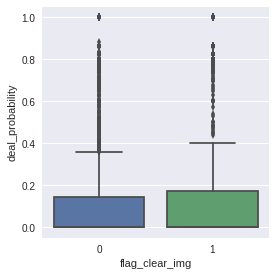

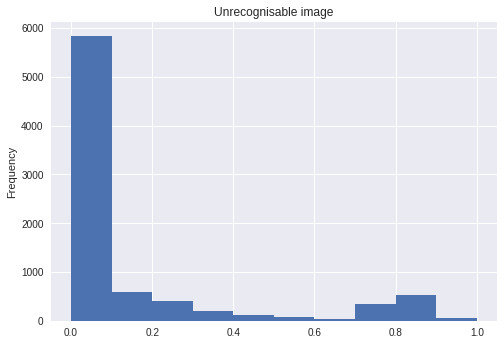

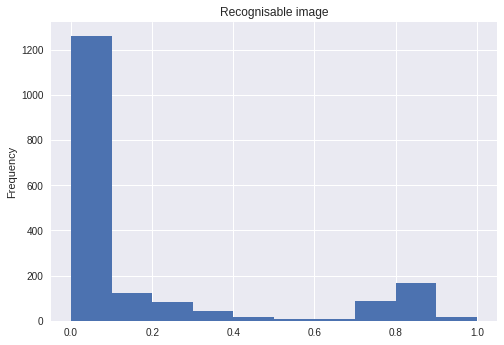

'\n                count        sum      mean  min  max  median\nflag_clear_img                                              \n0                 813  106.21661  0.130648  0.0  1.0     0.0\n1                 186   27.40012  0.147312  0.0  1.0     0.0\n'

In [0]:
#Check how different the deal probability on the recognisable (ResNet is more than 50% confident) and unrecognisable images (ResNet is <= 50% confident)
df_w_target = pd.merge(df, train_df, how = 'left', left_on='image_id', right_on='image')
print('check missing rate from merge:', df_w_target.deal_probability.isnull().sum())
print(df_w_target.groupby(df_w_target['flag_clear_img'])['deal_probability'].agg(['count','sum','mean','min','max','median']))
sns.factorplot(data = df_w_target, x = 'flag_clear_img', y = 'deal_probability', kind = 'box')
plt.show()
#Histogram
df_w_target.loc[df_w_target.flag_clear_img == 0]['deal_probability'].plot.hist()
plt.title('Unrecognisable image')
plt.show()
df_w_target.loc[df_w_target.flag_clear_img == 1]['deal_probability'].plot.hist()
plt.title('Recognisable image')
plt.show()

'''
================== Results On 1000 images ==================
                count        sum      mean  min  max  median
flag_clear_img                                              
0                 813  106.21661  0.130648  0.0  1.0     0.0
1                 186   27.40012  0.147312  0.0  1.0     0.0

================== Results On 10000 images ==================

                count         sum      mean  min  max  median
flag_clear_img                                               
0                8181  1133.61985  0.138567  0.0  1.0     0.0
1                1818   297.02736  0.163381  0.0  1.0     0.0
'''